In [ ]:
%load_ext autoreload
%autoreload 2
from awesome.run.awesome_config import AwesomeConfig
from awesome.run.awesome_runner import AwesomeRunner
from awesome.util.reflection import class_name
import os
import torch
from awesome.dataset.sisbosi_dataset import SISBOSIDataset, ConvexityDataset as SISBOSIConvexityDataset
from awesome.dataset.convexity_segmentation_dataset import ConvexitySegmentationDataset
from awesome.measures.awesome_loss import AwesomeLoss
from awesome.measures.regularizer_loss import RegularizerLoss
from awesome.model.convex_diffeomorphism_net import ConvexDiffeomorphismNet
from awesome.model.net import Net
import awesome
from awesome.util.path_tools import get_project_root_path
from awesome.util.logging import basic_config
import matplotlib.pyplot as plt
from awesome.analytics.result_model import ResultModel
from awesome.run.functions import get_result, split_model_result, plot_image_scribbles, plot_mask_labels
from awesome.util.temporary_property import TemporaryProperty
from awesome.run.functions import get_result, split_model_result,register_alpha_map, plot_image_scribbles, plot_mask_labels, plot_mask
import numpy as np
from matplotlib.colors import to_hex, to_rgb
import matplotlib

%matplotlib inline

import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from awesome.run.functions import get_mpl_figure
from typing import Literal
from awesome.dataset.awesome_dataset import AwesomeDataset
from awesome.dataset.fbms_sequence_dataset import FBMSSequenceDataset
from awesome.dataset.sisbosi_dataset import SISBOSIDataset, ConvexityDataset as SISBOSIConvexityDataset
from awesome.measures.awesome_image_loss_joint import AwesomeImageLossJoint
from awesome.measures.awesome_image_loss import AwesomeImageLoss
from awesome.measures.gradient_penalty_loss import GradientPenaltyLoss
from awesome.measures.fbms_joint_loss import FBMSJointLoss
from awesome.measures.regularizer_loss import RegularizerLoss
from awesome.model.cnn_net import CNNNet
from awesome.measures.tv import TV
from awesome.model.convex_net import ConvexNet
from awesome.model.unet import UNet
from awesome.measures.weighted_loss import WeightedLoss
from awesome.measures.se import SE
from awesome.measures.ae import AE
from tqdm.auto import tqdm
from awesome.measures.unaries_conversion_loss import UnariesConversionLoss
from awesome.model.wrapper_module import WrapperModule
#load_ext matplotlib
#matplotlib tk
import normflows as nf
basic_config()

os.chdir(get_project_root_path()) # Beeing in the root directory of the project is important for the relative paths to work consistently

In [ ]:
path = "./runs/fbms_local/eval/unet/spatio_temporal/UNET+cars3+edge+diffeo+spatio-temporal+realnvp_24_01_16_18_05_12"

result_model = ResultModel.from_path(path)
runner = result_model.get_runner(-1)

In [ ]:
import numpy as np
from awesome.run.functions import get_mpl_figure, get_result, split_model_result, get_prior_result
from awesome.model.path_connected_net import PathConnectedNet
from typing import Any
plt.close("all")

grid_shapes = dict()
model = runner.agent._get_model()
dataloader = runner.dataloader


index = list(range(0, len(dataloader), 1))

t_n = len(index)
t_max = len(dataloader) - 1

images = []
segmentations = []
priors_no_sig = []


with TemporaryProperty(model, use_prior_sigmoid=False), TemporaryProperty(dataloader, do_image_blurring=False):
    it = tqdm(index)
    for i in it:
        res_no_sig, ground_truth, img, _, _ = get_result(model, dataloader, i, False)
        res_no_sig = split_model_result(res_no_sig, model, dataloader, img)

        priors_no_sig.append(res_no_sig.get("prior_raw", None))

        res_pred = res_no_sig["segmentation"]

        images.append(img)
        segmentations.append(res_pred)

images = torch.stack(images)
segmentations = torch.stack(segmentations)
priors_no_sig = torch.stack(priors_no_sig)

shp = priors_no_sig.shape[-2:]
if shp not in grid_shapes:
    grid_shapes[shp] = PathConnectedNet.create_normalized_grid(shp).cpu().numpy()
grid = grid_shapes[priors_no_sig.shape[-2:]]


# Stack time 
pred = priors_no_sig # B x C x H x W
# Spatio temporal grid
t_grid = torch.stack([torch.cat([torch.tensor(grid[0]), torch.full((1, *pred.shape[-2:]), t / t_max)], dim=0) for t in index])


def plot_spatio_temporal_object(grid: Any, unaries: Any, size: float = 5):
    
    if isinstance(grid, torch.Tensor):
        grid = grid.cpu().numpy()
    if isinstance(unaries, torch.Tensor):
        unaries = unaries.cpu().numpy()
    
    if len(grid.shape) < 4:
        grid = grid[None]
    if len(unaries.shape) < 4:
        unaries = unaries[None]
    

    fig, ax = get_mpl_figure(subplot_kw=dict(projection='3d'))

    for i in range(grid.shape[0]):
        g = grid[i]
        u = unaries[i][0]

        z = u
        y = g[1]
        x = g[0]
        offset = g[2].max() # Offset is the time
        ax.contour(x, y, z, levels=[0.5], colors="red", offset=offset, linewidths=2)

    x_left, x_right = ax.get_xlim()
    y_low, y_high = ax.get_ylim()

    zoom= 1
    elevation = 130
    azimuth = 90
    roll = 0

    ax.set_box_aspect(aspect=((x_right-x_left)/(y_low-y_high), 1, 1), zoom=zoom)
    ax.view_init(elev=elevation, azim=azimuth, roll=roll)

    ax.invert_zaxis()

    #ax.set_axis_off()
    return fig
 
#fig = plot_spatio_temporal_object(t_grid, pred)
#fig


In [ ]:
def save_data(images, segmentations, priors_no_sig):
    path = f"output/temp/fbms_spatio_temporal_{dataloader.__dataset__.dataset_name}/"
    os.makedirs(path, exist_ok=True)

    with open(os.path.join(path, "segmentation.pth"), "wb") as f:
        torch.save(segmentations, f)

    with open(os.path.join(path, "iamges.pth"), "wb") as f:
        torch.save(images, f)
        
    with open(os.path.join(path, "priors_no_sig.pth"), "wb") as f:
        torch.save(priors_no_sig, f)

def load_data():
    path = f"output/temp/fbms_spatio_temporal_{dataloader.__dataset__.dataset_name}/"

    with open(os.path.join(path, "segmentation.pth"), "rb") as f:
        segmentations = torch.load(f)

    with open(os.path.join(path, "iamges.pth"), "rb") as f:
        images = torch.load(f)
        
    with open(os.path.join(path, "priors_no_sig.pth"), "rb") as f:
        prior_no_sig = torch.load(f)

    return images, segmentations, prior_no_sig

save_data(images, segmentations, priors_no_sig)

In [ ]:
intersample = (len(dataloader) * 2 -1) * 2 -1
spacing = 4
input_grid = PathConnectedNet.create_normalized_grid((intersample, *img.shape[1:]))
load_path = True
path = "./output/super_sample_result.pth"

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

if load_path:
    super_sample_result = torch.load(path, map_location=torch.device("cpu"))
else:
    super_sample_result = get_prior_result(model.prior_module, input_grid, 16, device)

image_idx_filler = ([x for x in list(range(len(super_sample_result))) if x % spacing == 0])
images_filled = len(super_sample_result) * [None]
for i, v in enumerate(image_idx_filler):
    images_filled[v] = images[i]


In [ ]:
from awesome.run.functions import plot_3d_tubes
import itertools

subsamplings = [3]
top_image_alphas = [0.2]


for subsampling, top_image_alpha in itertools.product(subsamplings, top_image_alphas):
    path = f"./output/spatio_temporal/tubes_{runner.dataloader.__dataset__.dataset_name}_subs_{subsampling}_alpha_{str(top_image_alpha).replace('.', '_')}"
    fig = plot_3d_tubes(priors_no_sig, images, 
                        top_image_alpha=top_image_alpha,
                        subsample_factor=subsampling,
                        subsample_image_mode="grid_sample",
                        grid_sample_mode="nearest",
                        transparent=True,
                        path=path, save=False, 
                        ext=["png", "pdf"], override=True)
    display(fig)
    plt.close(fig)

In [ ]:
from typing import List, Optional
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from matplotlib.colors import to_rgba, get_named_colors_mapping
import math
from awesome.util.torch import VEC_TYPE

color_prior = plt.get_cmap("tab10")(1)

def plot_frame_2d(prior: np.ndarray, 
                  image: Optional[VEC_TYPE], 
                  image_border_size: int = 10,
                  image_border_color: Any = "grey",
                  **kwargs) -> Figure: 
    if isinstance(image, torch.Tensor):
        image = image.permute(1,2,0).numpy()


    # If image is None, produce empty frame with a border
    if image is None:
        image = np.zeros((*prior.shape[-2:], 4))
    else:
        #Check if rgba
        if image.shape[-1] != 4:
            img = np.ones((*image.shape[:2], 4))
            img[..., :3] = image
            image = img

    if isinstance(image_border_color, str):
        cmap = get_named_colors_mapping()
        image_border_color = cmap.get(image_border_color)
    image_border_color = np.array(to_rgba(image_border_color)).reshape((1, 1, 4))
    image[ :image_border_size, :] = image_border_color
    image[ -image_border_size:, :] = image_border_color
    image[ :, :image_border_size] = image_border_color
    image[ :, -image_border_size:] = image_border_color
    fig = plot_mask(image, prior, **kwargs)
    return fig
    

def plot_interpolated_frames_2d(images: List[Optional[VEC_TYPE]], 
                                priors: torch.Tensor, 
                                plot_indices: List[int], 
                                image_path_prefix: str = "",
                                **kwargs) -> Figure:
    #ax = None
    img_name = image_path_prefix
    if len(img_name) > 0:
        img_name += "_"
        
    for idx in plot_indices:
        img = images[idx]
        p = no_sig_to_mask(priors[idx])
        path = img_name + "idx_" + str(idx)
        if img == None:
            path += "_interpolated"
        fig = plot_frame_2d(p, img, 
                            path=path,
                            image_border_size=5,
                            image_border_color="grey",
                            ext=["png"],
                            save=True,
                            override=True,
                            size=5, color=color_prior,darkening_background=0 if img is None else 0.7, 
                            tight=True, 
                            **kwargs)
        #ax = fig.axes[0]
        display(fig)
        plt.close(fig)

def no_sig_to_mask(prior_no_sigmoid: torch.Tensor) -> torch.Tensor:
    return torch.logical_not(torch.sigmoid(prior_no_sigmoid) > 0.5)

image_path_prefix = f"./output/spatio_temporal/frame_interpolation/{dataloader.__dataset__.dataset_name}"
plot_interpolated_frames_2d(images_filled, super_sample_result, plot_indices=list(range(60, 90)), image_path_prefix=image_path_prefix)


# Best frames 20 - 44
# Real frame is every 4 th frame
# Total frame in sequence 19, sequence length approx 0.7916 sec. @ 24 FPS 
# Total of interpolated Frames: 73 - First is real, last ist real, 3 interpolated frames in between each real frame
# One (interpolated) frame each 0.01084 secs 
 

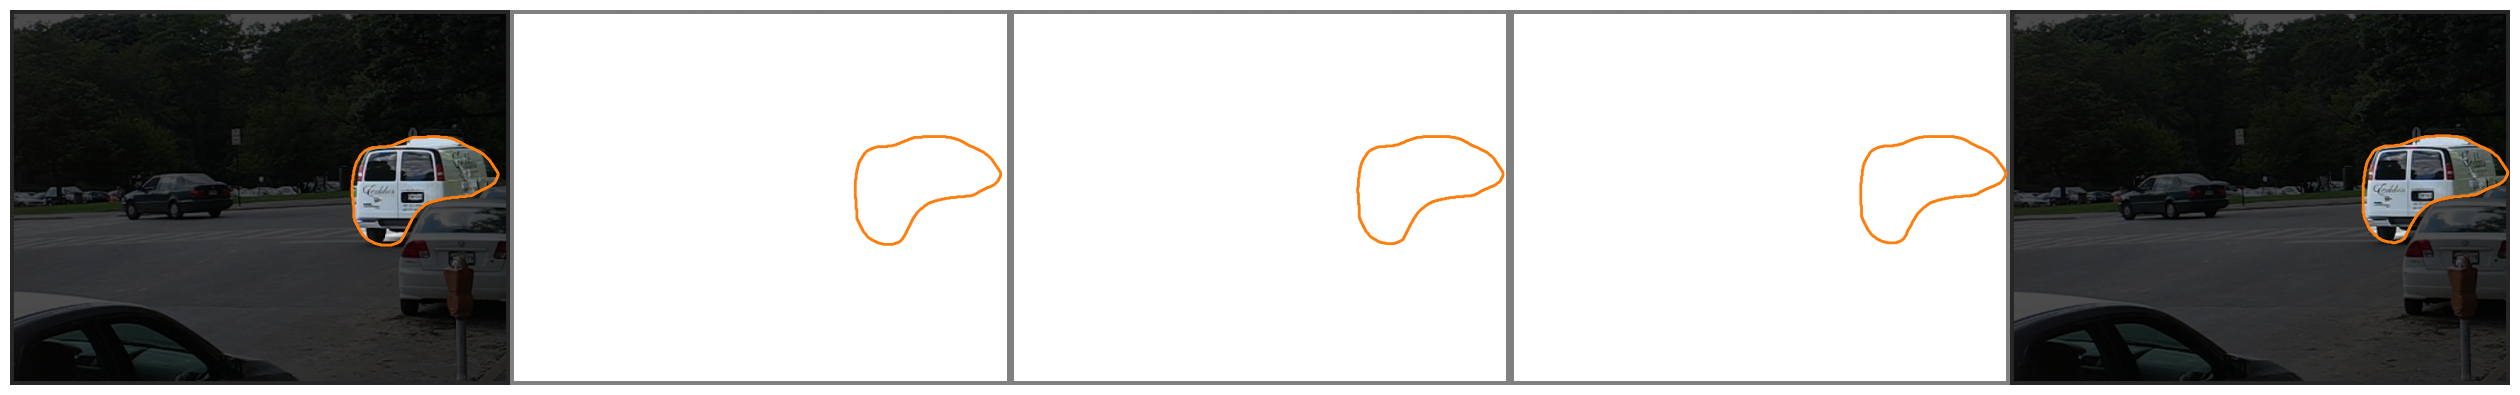

In [108]:
import math

from awesome.util.matplotlib import saveable
@saveable()
def plot_interpolated_frames_2d_combined(
                                images: List[Optional[VEC_TYPE]], 
                                priors: torch.Tensor, 
                                plot_indices: List[int], 
                                cols: int = 5,
                                size: float=5,
                                image_path_prefix: str = "",
                                **kwargs) -> Figure:
    #ax = None
    img_name = image_path_prefix
    if len(img_name) > 0:
        img_name += "_"

    rows = int(math.ceil(len(plot_indices) / cols))
    
    fig, axes = get_mpl_figure(rows, cols, size=size, tight=True, ratio_or_img=priors[0])
        
    for i, idx in enumerate(plot_indices):
        img = images[idx]
        p = no_sig_to_mask(priors[idx])
        fig = plot_frame_2d(p, img, 
                            image_border_size=5,
                            ax=axes[i],
                            image_border_color="grey",
                            color=color_prior,darkening_background=0 if img is None else 0.7, 
                            **kwargs)
        
    return fig

path = f"./output/spatio_temporal/frame_interpolation/{dataloader.__dataset__.dataset_name}_40_to_45"

fig = plot_interpolated_frames_2d_combined(images_filled, super_sample_result, 
                                           path=path,
                                           save=True,
                                           override=True,
                                           ext=["png", "pdf"],
                                           plot_indices=list(range(40, 45)))
display(fig)
plt.close(fig)

In [ ]:
from typing import List, Optional
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from matplotlib.colors import to_rgba, get_named_colors_mapping
from awesome.run.functions import create_grid_verticies, image_subsample
from awesome.transforms.min_max import minmax

from awesome.util.torch import VEC_TYPE

color_prior = plt.get_cmap("tab10")(1)
    
def plot_interpolated_frames_3d(images: List[Optional[VEC_TYPE]], 
                                priors: torch.Tensor, 
                                plot_indices: List[int], 
                                image_path_prefix: str = "",
                                **kwargs) -> Figure:
    selected_images = images[plot_indices]
    selected_priors = images[plot_indices]



image_path_prefix = f"./output/spatio_temporal/frame_interpolation/{dataloader.__dataset__.dataset_name}"
plot_interpolated_frames_3d(images_filled, super_sample_result, plot_indices=list(range(60, 90)), image_path_prefix=image_path_prefix)

 

In [ ]:
range(*tuple(slice(40, 45)))

In [ ]:
total_frames_time = len(dataloader) / 24
len_inter_frames = len(super_sample_result)
individual_frame_time = total_frames_time / len_inter_frames

select_frames = slice(40, 45)
def slice_to_range(s: slice, _len: int) -> Any:
    start, stop, step = s.indices(_len)
    return range(start, stop, step)

path = f"./output/spatio_temporal/frame_interpolation/{dataloader.__dataset__.dataset_name}_stacked_{'_'.join([str(x) for x in select_frames.indices(len_inter_frames)])}"

real_indices = {i for i, img in enumerate(images_filled) if img is not None}

plot_mask(images_filled[select_frames.indices(len_inter_frames)[0]], 
          no_sig_to_mask(super_sample_result[select_frames, 0]), 
          path=path,
          ext=["png", "pdf"],
          save=True,
          tight=True,
          override=True,
          labels=[f"{round(x * individual_frame_time * 1000)} ms {'*' if x not in real_indices else ' '}" for x in slice_to_range(select_frames, len_inter_frames)],
          size=5
          )

In [ ]:
[str(x) for x in select_frames.indices(len_inter_frames)]

In [ ]:
select_frames.indices(len_inter_frames)[0]

In [ ]:
super_sample_result[:5, 0].shape

In [ ]:
super_sample_result[:30, 0].shape

In [ ]:
images.shape

In [ ]:
from awesome.run.functions import plot_3d_tubes
import itertools

subsamplings = [3]
top_image_alphas = [0.2]


for subsampling, top_image_alpha in itertools.product(subsamplings, top_image_alphas):
    path = f"./output/spatio_temporal/tubes_hr_{runner.dataloader.__dataset__.dataset_name}_subs_{subsampling}_alpha_{str(top_image_alpha).replace('.', '_')}"
    fig = plot_3d_tubes(super_sample_result, images_filled, 
                        top_image_alpha=top_image_alpha,
                        subsample_factor=subsampling,
                        subsample_image_mode="grid_sample",
                        grid_sample_mode="nearest",
                        z_ticks_max=18,
                        z_ticks_step=5,
                        transparent=True,
                        path=path, save=True, ext=["png", "pdf"], override=True)
    display(fig)
    plt.close(fig)

In [7]:
path = "./output/super_sample_result.pth"

with open(path, "wb") as f:
    torch.save(super_sample_result, f)

In [6]:
from awesome.model.net_factory import init_realnvp

realnvp = init_realnvp(2, hidden_units=32, output_fn="tanh", height=100, width=100, n_flows=12)

x = torch.rand(4, 2)

display(x)

with torch.no_grad():
    z = realnvp(x)
    display(z)

with torch.no_grad():
    xr = realnvp.inverse(z)
    display(xr)

In [ ]:
x = super_sample_result[0][None, ...]

In [ ]:
from awesome.util.torch import TensorUtil


x = input_grid[0][None]
x = model.prior_module.linear(x)

TensorUtil.apply_deep(model, lambda x: x.to(device=torch.device("cpu")))

with torch.no_grad():
    display(x)
    z = model.prior_module.get_deformation(x)
    display(z)
    x_t = model.prior_module.inverse(z)
    display(torch.isclose(x, x_t, atol=1e-5).all())

In [ ]:
model.prior_module.linear.weight

In [ ]:
torch.manual_seed(0)
x = torch.rand(1, 3, 150, 100) 
W = model.prior_module.linear.weight
b = model.prior_module.linear.bias



In [ ]:
# Inverse

def forward(x, W, b):
    with torch.no_grad():
        out = torch.zeros_like(x)
        for i in range(x.shape[0]):
            for c in range(x.shape[1]):
                out[i, c] = b[c] + (W[c, 0]) * x[i, c]
        return out

def inverse(x, W, b):
    with torch.no_grad():
        out = torch.zeros_like(x)
        for i in range(x.shape[0]):
            for c in range(x.shape[1]):
                out[i, c] = (1 / W[c, 0]) * (x[i, c] - b[c])
        return out
    
assert torch.isclose(forward(x, W, b), model.prior_module.linear(x)).all()
assert torch.isclose(inverse(forward(x, W, b), W, b), x).all()

In [ ]:
x.shape

In [ ]:
with torch.no_grad():
    display(model.prior_module.linear(x))

In [ ]:
out.shape

In [ ]:
y.shape

In [ ]:
W.shape

In [ ]:
TensorUtil.apply_deep(model, lambda x: x.to(device=torch.device("cpu")))

In [ ]:
next(model.parameters()).device

In [ ]:
x

In [ ]:
z.shape

In [ ]:
from awesome.run.functions import plot_3d_tubes

path = f"./notebooks/output/spatio_temporal/tubes_no_sub_{runner.dataloader.__dataset__.dataset_name}"
fig = plot_3d_tubes(priors_no_sig, images, subsample_x=1, subsample_y=1, path=path, save=True, ext=["png", "pdf"], override=True)
display(fig)

plt.close(fig)


In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.colors import to_rgba
from skimage import measure

plt.close("all")


subsample_x = 6
subsample_y = 6


def plot_3d_tubes(logits, images, subsample_x = 6, subsample_y = 6):
    vol = priors_no_sig[:, 0, ::subsample_y, ::subsample_x].cpu().numpy()

    # Use marching cubes to obtain the surface mesh of these ellipsoids
    verts, faces, normals, values = measure.marching_cubes(vol.T, 0)

    # Display resulting triangular mesh using Matplotlib. This can also be done
    # with mayavi (see skimage.measure.marching_cubes docstring).
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    image_index = 18
    rgb_img = images[image_index, :, ::subsample_y, ::subsample_x].permute(1, 2, 0).numpy()

    x = np.arange(0, rgb_img.shape[-2], 1)
    y = np.arange(0, rgb_img.shape[-3], 1)
    xx, yy = np.meshgrid(x, y)


    facecolor = plt.get_cmap("tab10")(1)
    edgecolor = None

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], shade=True, facecolors=facecolor, edgecolor='none', linewidth=0, antialiased=False,)
    ax.add_collection3d(mesh)


    def create_grid_verticies(grid, z_loc):
        indices = np.argwhere(grid.T >= 0)
        repeated = indices[:, None, :].repeat(4, axis=1)
        repeated[:, 1, 1] += 1 # Added one to x
        repeated[:, 2, :] += 1 # Added one to x and y
        repeated[:, 3, 0] += 1 # Added one to y
        # Add constant z
        zz = np.zeros_like(repeated[:, :, 0])[..., None]
        zz.fill(z_loc)
        vertices_img = np.concatenate([repeated, zz], axis=-1)
        return vertices_img


    fcol = rgb_img.reshape((math.prod(rgb_img.shape[:-1]), 3), order="F")
    secmesh = Poly3DCollection(create_grid_verticies(xx, image_index), shade=True, facecolors=fcol, edgecolor='none', linewidth=0, antialiased=False)
    ax.add_collection3d(secmesh)

    front_index = 0
    front_img = images[front_index, :, ::subsample_y, ::subsample_x].permute(1, 2, 0).numpy()

    fcol_front = front_img.reshape((math.prod(front_img.shape[:-1]), 3), order="F")
    # Stack alpha
    fcol_front = np.concatenate([fcol_front, np.zeros_like(fcol_front[:, 0])[..., None]], axis=-1)

    # Set alpha to 0 for all pixels that are not in the foreground
    subsample_df_prior = priors_no_sig[front_index, :, ::subsample_y, ::subsample_x][0].numpy()
    fg = (subsample_df_prior <= 0).reshape((math.prod(subsample_df_prior.shape), 1), order="F")
    fcol_front[fg[:, 0], 3] = 1

    thirdmesh = Poly3DCollection(create_grid_verticies(xx, front_index), shade=True, facecolors=fcol_front, edgecolor='none', linewidth=0, antialiased=False)
    ax.add_collection3d(thirdmesh)


    #ax.plot_surface(xx, yy, np.zeros_like(xx), facecolors=rgb_img, rcount=rgb_img.shape[-2], ccount=rgb_img.shape[-3], zorder=0)


    #secmesh = Poly3DCollection(verts[faces] + np.array([[0, 0, 10]]), shade=True, facecolors=facecolor, edgecolor=edgecolor, zorder=1)
    #ax.add_collection3d(secmesh)


    #y_max, x_max = xx.shape

    # # Create axis like arrows for x, y and z
    # vec_len = 5
    # x_arrow = np.array([[0, y_max, 0], [vec_len, 0, 0]])
    # y_arrow = np.array([[0, y_max, 0], [0, -vec_len, 0]])
    # z_arrow = np.array([[0, y_max, 0], [0, 0, vec_len]])

    # arrow_starts = np.stack([x_arrow[0], 
    #                     y_arrow[0],
    #                     z_arrow[0]])
    # arrow_directions = np.stack([
    #                     x_arrow[1],
    #                     y_arrow[1],
    #                     z_arrow[1]])

    # base_length_ratio = (len(images) - 1) * 0.1

    # for i in range(len(arrow_starts)):
    #     len_vec = np.linalg.norm(arrow_directions[i])
    #     ax.quiver(arrow_starts[i, 0], arrow_starts[i, 1], arrow_starts[i, 2], 
    #             arrow_directions[i, 0], arrow_directions[i, 1], arrow_directions[i, 2], color="black", zorder=10, 
    #             normalize=True,
    #              linewidths=2)



    #light_source = mpl.colors.LightSource(azdeg=315, altdeg=10)


    ax.set_xlim(0, vol.shape[-1])  
    ax.set_ylim(0, vol.shape[-2]) 
    ax.set_zlim(0, vol.shape[-3])  

    #ax.set_xlabel('X')
    #ax.set_ylabel('Y')
    ax.set_zlabel('Time [t]')

    ax.view_init(elev=40, azim=90, roll=0)

    ax.invert_xaxis()
    ax.invert_zaxis()

    ax.grid(False)
    ax.xaxis.line.set_lw(0.)
    ax.set_xticks([])

    ax.yaxis.line.set_lw(0.)
    ax.set_yticks([])

    t = np.arange(0, len(images), 1)[::5]
    ax.set_zticks(t, labels=t.astype(int))

    ax.set_aspect('equalxy')

    return fig
#ax.set_axis_off()
#plt.tight_layout()
plt.show()

In [ ]:

ax.get_zticks()